<a href="https://colab.research.google.com/github/pbeles/pbeles-NLP_project_j/blob/main/BERT01_NEW_DATASET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
1708/1708 [==============================] - 163s 72ms/step - loss: 0.0962 - accuracy: 0.9650
Epoch 2/2
1708/1708 [==============================] - 47s 26ms/step - loss: 0.0118 - accuracy: 0.9965


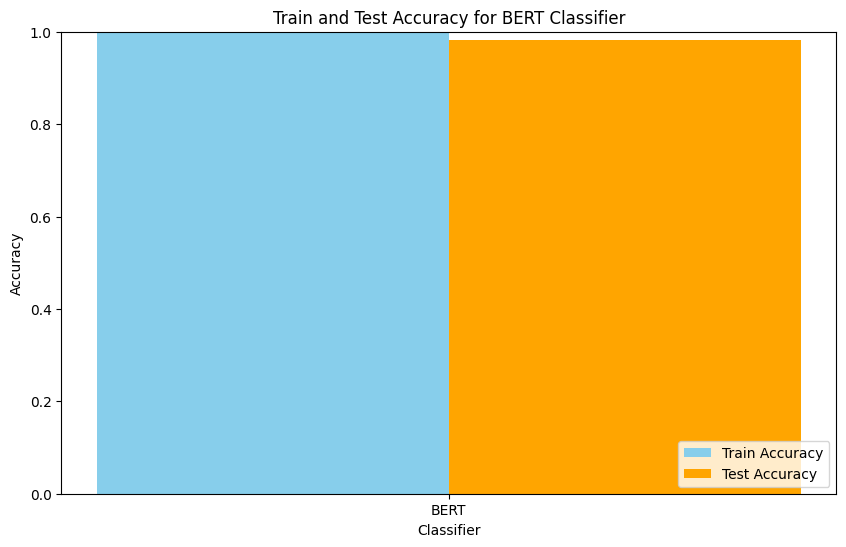

Test Accuracy for BERT Classifier: 98.21%
427/427 [==============================] - 14s 25ms/step
First 50 Predictions for BERT Classifier:
[1 1 1 0 0 1 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 0 1 0 0 1 1 0 0 0 1
 1 1 1 1 1 0 1 0 0 0 0 1 0]


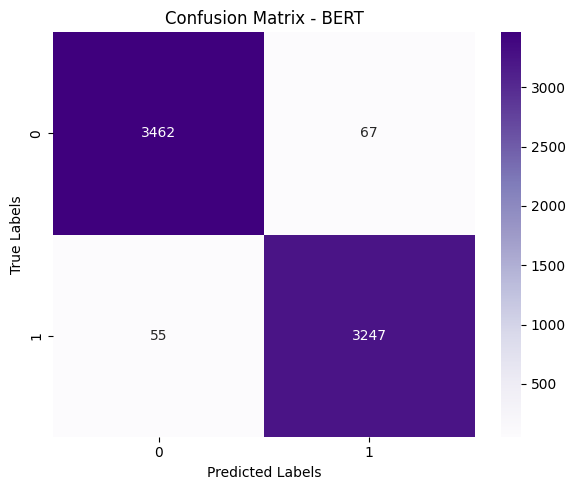

Model and tokenizer saved successfully.


In [1]:
import pandas as pd
import re
import string
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score, roc_curve, roc_auc_score, precision_recall_curve
from transformers import BertTokenizer, TFBertForSequenceClassification
import tensorflow as tf
import numpy as np
import os
from google.colab import files
import pickle
import warnings

# Suppress warnings from Hugging Face
warnings.filterwarnings("ignore", category=UserWarning, module="transformers")

# Load dataset
file_path = '/content/training_data_lowercase.csv'

if not os.path.exists(file_path):
    print("File not found. Please upload the dataset.")
    uploaded = files.upload()
    file_path = list(uploaded.keys())[0]

data = pd.read_csv(file_path, delimiter='\t', header=None, names=['label', 'text'])

# Train-test split
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Data Preprocessing
def preprocess_text(text):
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove single characters
    text = re.sub(r'\b[a-zA-Z]\b', '', text)
    # Substitute multiple spaces with single space
    text = re.sub(r'\s+', ' ', text)
    # Convert to lowercase
    text = text.lower()
    return text

# Define stopwords using NLTK
nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# Remove stopwords function
def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in stop_words])

# Lemmatize text (placeholder function)
def lemmatize_text(text):
    return ' '.join([word for word in text.split()])  # This will keep the words unchanged

# Apply preprocessing, stopword removal, and lemmatization
train_data['processed_text'] = train_data['text'].apply(preprocess_text)
test_data['processed_text'] = test_data['text'].apply(preprocess_text)

train_data['processed_text'] = train_data['processed_text'].apply(remove_stopwords)
test_data['processed_text'] = test_data['processed_text'].apply(remove_stopwords)

train_data['processed_text'] = train_data['processed_text'].apply(lemmatize_text)
test_data['processed_text'] = test_data['processed_text'].apply(lemmatize_text)

# BERT Classifier
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Tokenizing the text for BERT
train_encodings = bert_tokenizer(list(train_data['text']), truncation=True, padding=True, max_length=128)
test_encodings = bert_tokenizer(list(test_data['text']), truncation=True, padding=True, max_length=128)

train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), train_data['label'])).batch(16)
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), test_data['label'])).batch(16)

# Compile and train BERT model
bert_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
bert_model.fit(train_dataset, epochs=2, batch_size=16)

# Evaluate BERT model
bert_eval = bert_model.evaluate(test_dataset)
bert_train_accuracy = bert_model.evaluate(train_dataset)[1]
bert_test_accuracy = bert_eval[1]

# Combined Bar Plot for Train and Test Accuracy
plt.figure(figsize=(10, 6))
indices = np.arange(1)
width = 0.3

train_accuracies = [bert_train_accuracy]
test_accuracies = [bert_test_accuracy]
classifiers = ['BERT']

plt.bar(indices - width/2, train_accuracies, width, color='skyblue', label='Train Accuracy')
plt.bar(indices + width/2, test_accuracies, width, color='orange', label='Test Accuracy')

plt.ylim(0, 1)
plt.xlabel('Classifier')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy for BERT Classifier')
plt.xticks(indices, classifiers)
plt.legend(loc='lower right')
plt.show()

# Print test accuracy for BERT classifier
print("Test Accuracy for BERT Classifier: {:.2f}%".format(bert_test_accuracy * 100))

# Generate predictions for BERT
y_pred_bert_logits = bert_model.predict(test_dataset).logits
y_pred_bert = np.argmax(y_pred_bert_logits, axis=1)

# Print first 50 predictions for BERT Classifier
print("First 50 Predictions for BERT Classifier:")
print(y_pred_bert[:50])

# Confusion Matrix for BERT
conf_matrix_bert = confusion_matrix(test_data['label'], y_pred_bert)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_bert, annot=True, cmap='Purples', fmt='g')
plt.title('Confusion Matrix - BERT')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.show()

# Save the tokenizer and model
bert_tokenizer.save_pretrained('/content/bert_tokenizer')
bert_model.save_pretrained('/content/bert_model')

# Save vectorizer if applicable (this is a placeholder for an actual vectorizer if used)
# Since BERT tokenizer is used, there isn't a typical vectorizer like TF-IDF or CountVectorizer in this case
# But if you had a vectorizer in use, you'd save it as shown below:
# vectorizer = TfidfVectorizer()  # Example placeholder
# pickle.dump(vectorizer, open('/content/vectorizer.pkl', 'wb'))

print("Model and tokenizer saved successfully.")


Second excercise

In [4]:
# Predict labels for new dataset
new_file_path = '/content/data_test_news_only.csv'

if not os.path.exists(new_file_path):
    print("File not found. Please upload the new dataset.")
    uploaded = files.upload()
    new_file_path = list(uploaded.keys())[0]

new_data = pd.read_csv(new_file_path, delimiter='\t', header=None, names=['text'])

# Preprocess new data
new_data['processed_text'] = new_data['text'].apply(preprocess_text)
new_data['processed_text'] = new_data['processed_text'].apply(remove_stopwords)
new_data['processed_text'] = new_data['processed_text'].apply(lemmatize_text)

# Load saved model, tokenizer, and vectorizer
saved_tokenizer = BertTokenizer.from_pretrained('/content/bert_tokenizer')
saved_model = TFBertForSequenceClassification.from_pretrained('/content/bert_model')
try:
    saved_vectorizer = pickle.load(open('/content/vectorizer.pkl', 'rb'))
except FileNotFoundError:
    saved_vectorizer = None
    print("No vectorizer found. Skipping vectorizer step.")

# Tokenize new data
new_encodings = saved_tokenizer(list(new_data['processed_text']), truncation=True, padding=True, max_length=128)
new_dataset = tf.data.Dataset.from_tensor_slices((dict(new_encodings))).batch(16)

# Predict labels for new data
y_pred_new_logits = saved_model.predict(new_dataset).logits
y_pred_new = np.argmax(y_pred_new_logits, axis=1)

# Save predicted labels to CSV
new_data['label'] = y_pred_new
new_data.to_csv('/content/labeled_new_dataset.csv', index=True)

print("Predicted labels saved to 'labeled_new_dataset.csv'")


Some layers from the model checkpoint at /content/bert_model were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at /content/bert_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


No vectorizer found. Skipping vectorizer step.
624/624 [==============================] - 18s 24ms/step
Predicted labels saved to 'labeled_new_dataset.csv'
